In [1]:
# imports
from datamodel import OrderDepth, UserId, TradingState, Order, Observation, ConversionObservation
from typing import List, Dict, Tuple, Any
import string
import json
import jsonpickle
import numpy as np
import math
from math import log, sqrt, exp
from dataclasses import dataclass
from statistics import NormalDist
import random
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
file_path = "/Users/vasudev/Desktop/Projects/imc_prosperity/prosperity-imc25/rounds/round5/eda/logs/cfb2a760-6439-4fb1-8ebb-33cf2ebe94b8_final.log"

In [3]:
@dataclass
class Trade:
    timestamp: int
    buyer: str
    seller: str
    symbol: str
    currency: str
    price: float
    quantity: int

def parse_logs(file_path: str) -> Tuple[str, pd.DataFrame, List[Any]]:
    # Read entire log file
    with open(file_path, 'r') as f:
        content = f.read()

    # --- Parse Sandbox Logs ---
    sandbox_start = content.find('Sandbox logs:')
    activities_start = content.find('Activities log:')
    sandbox_section = content[sandbox_start + len('Sandbox logs:'):activities_start].strip()

    # --- Parse Activities Log ---
    trades_start = content.find('Trade History:')
    activities_section = content[activities_start + len('Activities log:'):trades_start].strip()

    # Read CSV section into a DataFrame
    activities_df = pd.read_csv(StringIO(activities_section), sep=';')

    # --- Parse Trades ---
    trades_section = content[trades_start + len('Trade History:'):].strip()
    trades_data = json.loads(trades_section)

    # Convert to Trade objects
    trades: List[Any] = [Trade(**t) for t in trades_data]

    return sandbox_section, activities_df, trades

sandbox_section, activities_df, trades = parse_logs(file_path)

In [4]:
trades_df = pd.DataFrame([t.__dict__ for t in trades])
our_trades = [trade for trade in trades if trade.buyer == "SUBMISSION" or trade.seller == "SUBMISSION"]
our_trades_df = pd.DataFrame([trade.__dict__ for trade in our_trades])
print(len(our_trades_df))

30414


In [5]:
# Sort the trades chronologically
our_trades_sorted = sorted(our_trades, key=lambda x: x.timestamp)

# Extract all unique timestamps and products from the activities dataframe
timestamps = sorted(activities_df['timestamp'].unique())
symbols = activities_df['product'].unique()

# Keep track of running position
running_pos = defaultdict(int)
records = []

# Pointer for iterating through our_trades_sorted
t_idx = 0

for t in timestamps:
    # Apply all trades that occurred at this timestamp
    while t_idx < len(our_trades_sorted) and our_trades_sorted[t_idx].timestamp == t:
        trade = our_trades_sorted[t_idx]
        if trade.buyer == "SUBMISSION":
            running_pos[trade.symbol] += trade.quantity
        elif trade.seller == "SUBMISSION":
            running_pos[trade.symbol] -= trade.quantity
        t_idx += 1

    # Record the position for all products at this timestamp
    for symbol in symbols:
        records.append({'timestamp': t, 'product': symbol, 'position': running_pos[symbol]})

# Create DataFrame of positions and merge
position_df = pd.DataFrame(records)
activities_df = activities_df.merge(position_df, on=['timestamp', 'product'], how='left')

# PRODUCT DICT

In [6]:
products = [
    "RAINFOREST_RESIN",
    "KELP", "SQUID_INK",
    "CROISSANTS", "JAMS",
    "DJEMBES", "PICNIC_BASKET1",
    "PICNIC_BASKET2",
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500", "MAGNIFICENT_MACARONS"
]

product_params = {"RAINFOREST_RESIN": {
                "pos_lim": 50,
                "fair_value": 10000,
                "take_buy_width": 1,
                "take_sell_width": 1,
            },
            "KELP": {
                "pos_lim": 50,
                "take_buy_width": 1,
                "take_sell_width": 1,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "reversion_beta": 1.4733,
                "mm_size": 15
            },
            "SQUID_INK": {
                "pos_lim": 50,
                "take_buy_width": 1,
                "take_sell_width": 1,
                "clear_width": -1,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "mm_size": 15,
                "reversion_beta": -1.097,
            },
            "CROISSANTS": {
                "pos_lim": 250,
                "take_buy_width": 1,
                "take_sell_width": 1,
                "make_buy_width": 2,
                "make_sell_width": 2,
            },
            "JAMS": {
                "pos_lim": 350,
                "take_buy_width": 1,
                "take_sell_width": 1,
                "make_buy_width": 2,
                "make_sell_width": 2,
            },
            "DJEMBES": {
                "pos_lim": 60,
                "take_buy_width": 1,
                "take_sell_width": 1,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "arb_strat_width": 20,
            },
            "PICNIC_BASKET1": {
                "pos_lim": 60,
                "take_buy_width": 10,
                "take_sell_width": 10,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "premium": -152.22,
            },
            "PICNIC_BASKET2": {
                "pos_lim": 100,
                "take_buy_width": 16,
                "take_sell_width": 16,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "premium": 66.108,
            },
            "VOLCANIC_ROCK": {
                "pos_lim": 400,
                "strikes": [
                    9500, 9750, 10000, 10250, 10500
                ]
            },
            "VOLCANIC_ROCK_VOUCHER_9500": {
                "pos_lim": 200,
                "take_buy_width": 0,
                "take_buy_width": 0,
                "make_sell_width": 2,
                "make_sell_width": 2,
                "clear_width": 1,
                "upper_threshold": 0.00322,
                "lower_threshold": -0.01665,
                "critical_boundary": 0.001,
                "premium": 0.0,
            },
            "VOLCANIC_ROCK_VOUCHER_9750": {
                "pos_lim": 200,
                "take_buy_width": 1.77,
                "take_sell_width": 1.91,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "clear_width": 1,
                "upper_threshold": 0.03894,
                "lower_threshold": -0.00803,
                "critical_boundary": 0.002,
                "premium": 0.0,
            },
            "VOLCANIC_ROCK_VOUCHER_10000": {
                "pos_lim": 200,
                "take_buy_width": 1,
                "take_sell_width": 3,
                "make_buy_width": 1.5,
                "make_sell_width": 1,
                "clear_width": 0,
                "upper_threshold": 0.00534,
                "lower_threshold": -0.01640,
                "critical_boundary": 0.002,
                "premium": 0.0,
            },
            "VOLCANIC_ROCK_VOUCHER_10250": {
                "pos_lim": 200,
                "take_buy_width": 0.55,
                "take_sell_width": 0.53,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "upper_threshold": 0.00502,
                "lower_threshold": -0.02194,
                "critical_boundary": 0.002,
                "premium": 0.0,
            },
            "VOLCANIC_ROCK_VOUCHER_10500": {
                "pos_lim": 200,
                "take_buy_width": 0,
                "take_sell_width": 0,
                "make_buy_width": 2,
                "make_sell_width": 2,
                "upper_threshold": float("inf"),
                "lower_threshold": float("-inf"),
                "critical_boundary": 0.0,
                "premium": 0.0,
            },
            "MAGNIFICENT_MACARONS": {
                "pos_lim": 75,
                "storage_cost": 0.1,
                "take_buy_width": 1,
                "take_sell_width": 1,
                "make_width": 1,
                "arbitrage_width": 0,
                "critical_sunlight_index": 46,
                "conversion_limit": 10,
                "mm_size": 21,
                "size_cap": 30,
                "clear_width": 1,
                "position_threshold": 50
            }
}

product_dict = {
    product: {
        "order_book": activities_df[activities_df['product'] == product],
        "trades": trades_df[trades_df['symbol'] == product],
        "pos_lim": product_params[product]["pos_lim"],
    }
    for product in products
}
# check length of product_dict
print("Length of product_dict:", len(product_dict))

Length of product_dict: 15


# POSITIONS

In [7]:
product_dict["SQUID_INK"]["order_book"].head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,position
10,5,0,SQUID_INK,1899.0,22.0,NaN,NaN,NaN,NaN,1902,22,NaN,NaN,NaN,NaN,1900.5,0.0,0
16,5,100,SQUID_INK,1899.0,28.0,NaN,NaN,NaN,NaN,1900,5,1902.0,28.0,NaN,NaN,1899.5,0.0,0
37,5,200,SQUID_INK,1900.0,24.0,NaN,NaN,NaN,NaN,1903,24,NaN,NaN,NaN,NaN,1901.5,0.0,0
59,5,300,SQUID_INK,1900.0,30.0,NaN,NaN,NaN,NaN,1903,30,NaN,NaN,NaN,NaN,1901.5,0.0,0
61,5,400,SQUID_INK,1899.0,20.0,NaN,NaN,NaN,NaN,1903,20,NaN,NaN,NaN,NaN,1901.0,0.0,0
82,5,500,SQUID_INK,1901.0,5.0,1900.0,2.0,1899.0,27.0,1903,29,NaN,NaN,NaN,NaN,1902.0,0.0,0
90,5,600,SQUID_INK,1900.0,24.0,NaN,NaN,NaN,NaN,1903,24,NaN,NaN,NaN,NaN,1901.5,0.0,0
109,5,700,SQUID_INK,1901.0,4.0,1900.0,31.0,NaN,NaN,1903,31,NaN,NaN,NaN,NaN,1902.0,0.0,0
128,5,800,SQUID_INK,1899.0,23.0,NaN,NaN,NaN,NaN,1902,23,NaN,NaN,NaN,NaN,1900.5,0.0,0
136,5,900,SQUID_INK,1900.0,21.0,NaN,NaN,NaN,NaN,1903,21,NaN,NaN,NaN,NaN,1901.5,0.0,0


In [8]:
voucher_products = [
    "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500"
]

voucher_positions = position_df[position_df['product'].isin(voucher_products)]

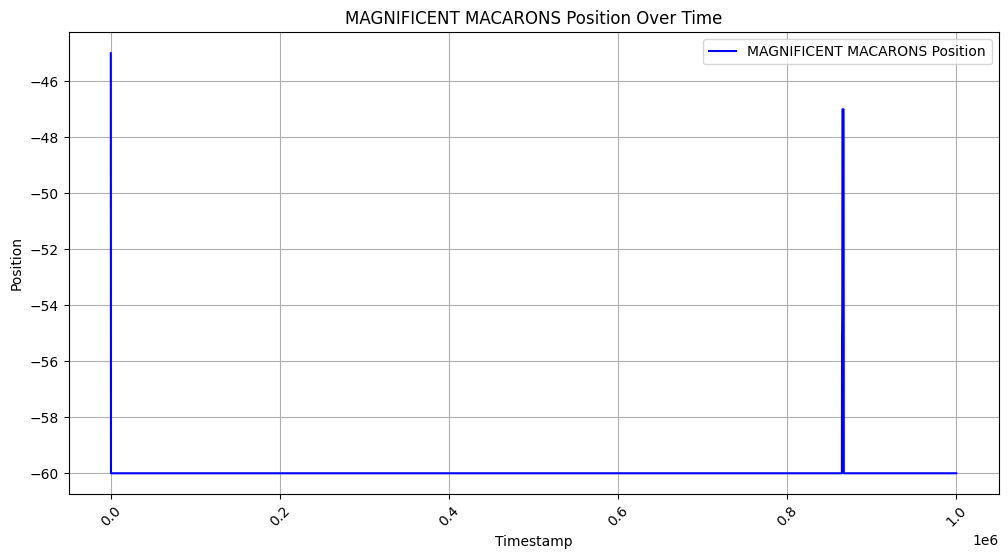

In [9]:
# MAGNIFICENT MACARONS POSITION
macarons_positions = position_df[position_df['product'] == "PICNIC_BASKET1"]

plt.figure(figsize=(12, 6))
plt.plot(macarons_positions['timestamp'], macarons_positions['position'], label='MAGNIFICENT MACARONS Position', color='blue')
plt.title('MAGNIFICENT MACARONS Position Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Position')
plt.xticks(rotation=45)
plt.grid()
plt.legend()


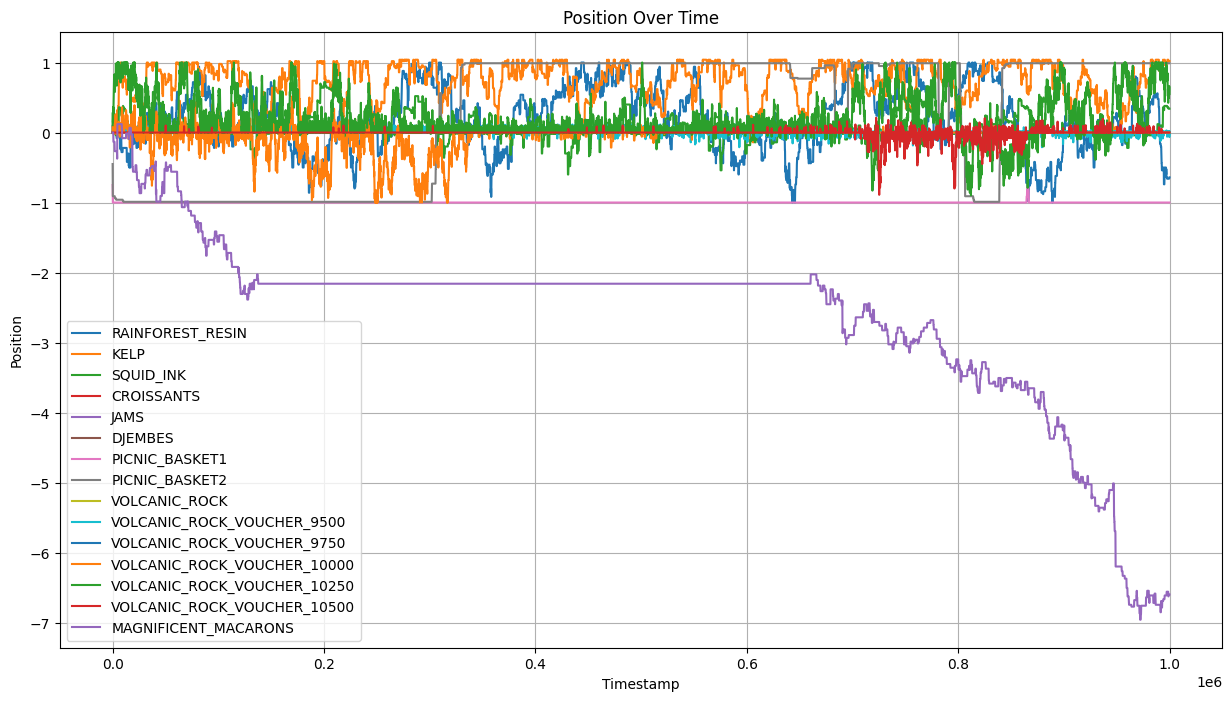

In [10]:
plt.figure(figsize=(15, 8))

for product, dict in product_dict.items():
    # Plot position
    plt.plot(dict['order_book']['timestamp'], dict['order_book']['position']/dict['pos_lim'], label=product)
    plt.xlabel('Timestamp')
    plt.ylabel('Position')
    plt.title('Position Over Time')
    plt.legend()
    plt.grid()


# PNL

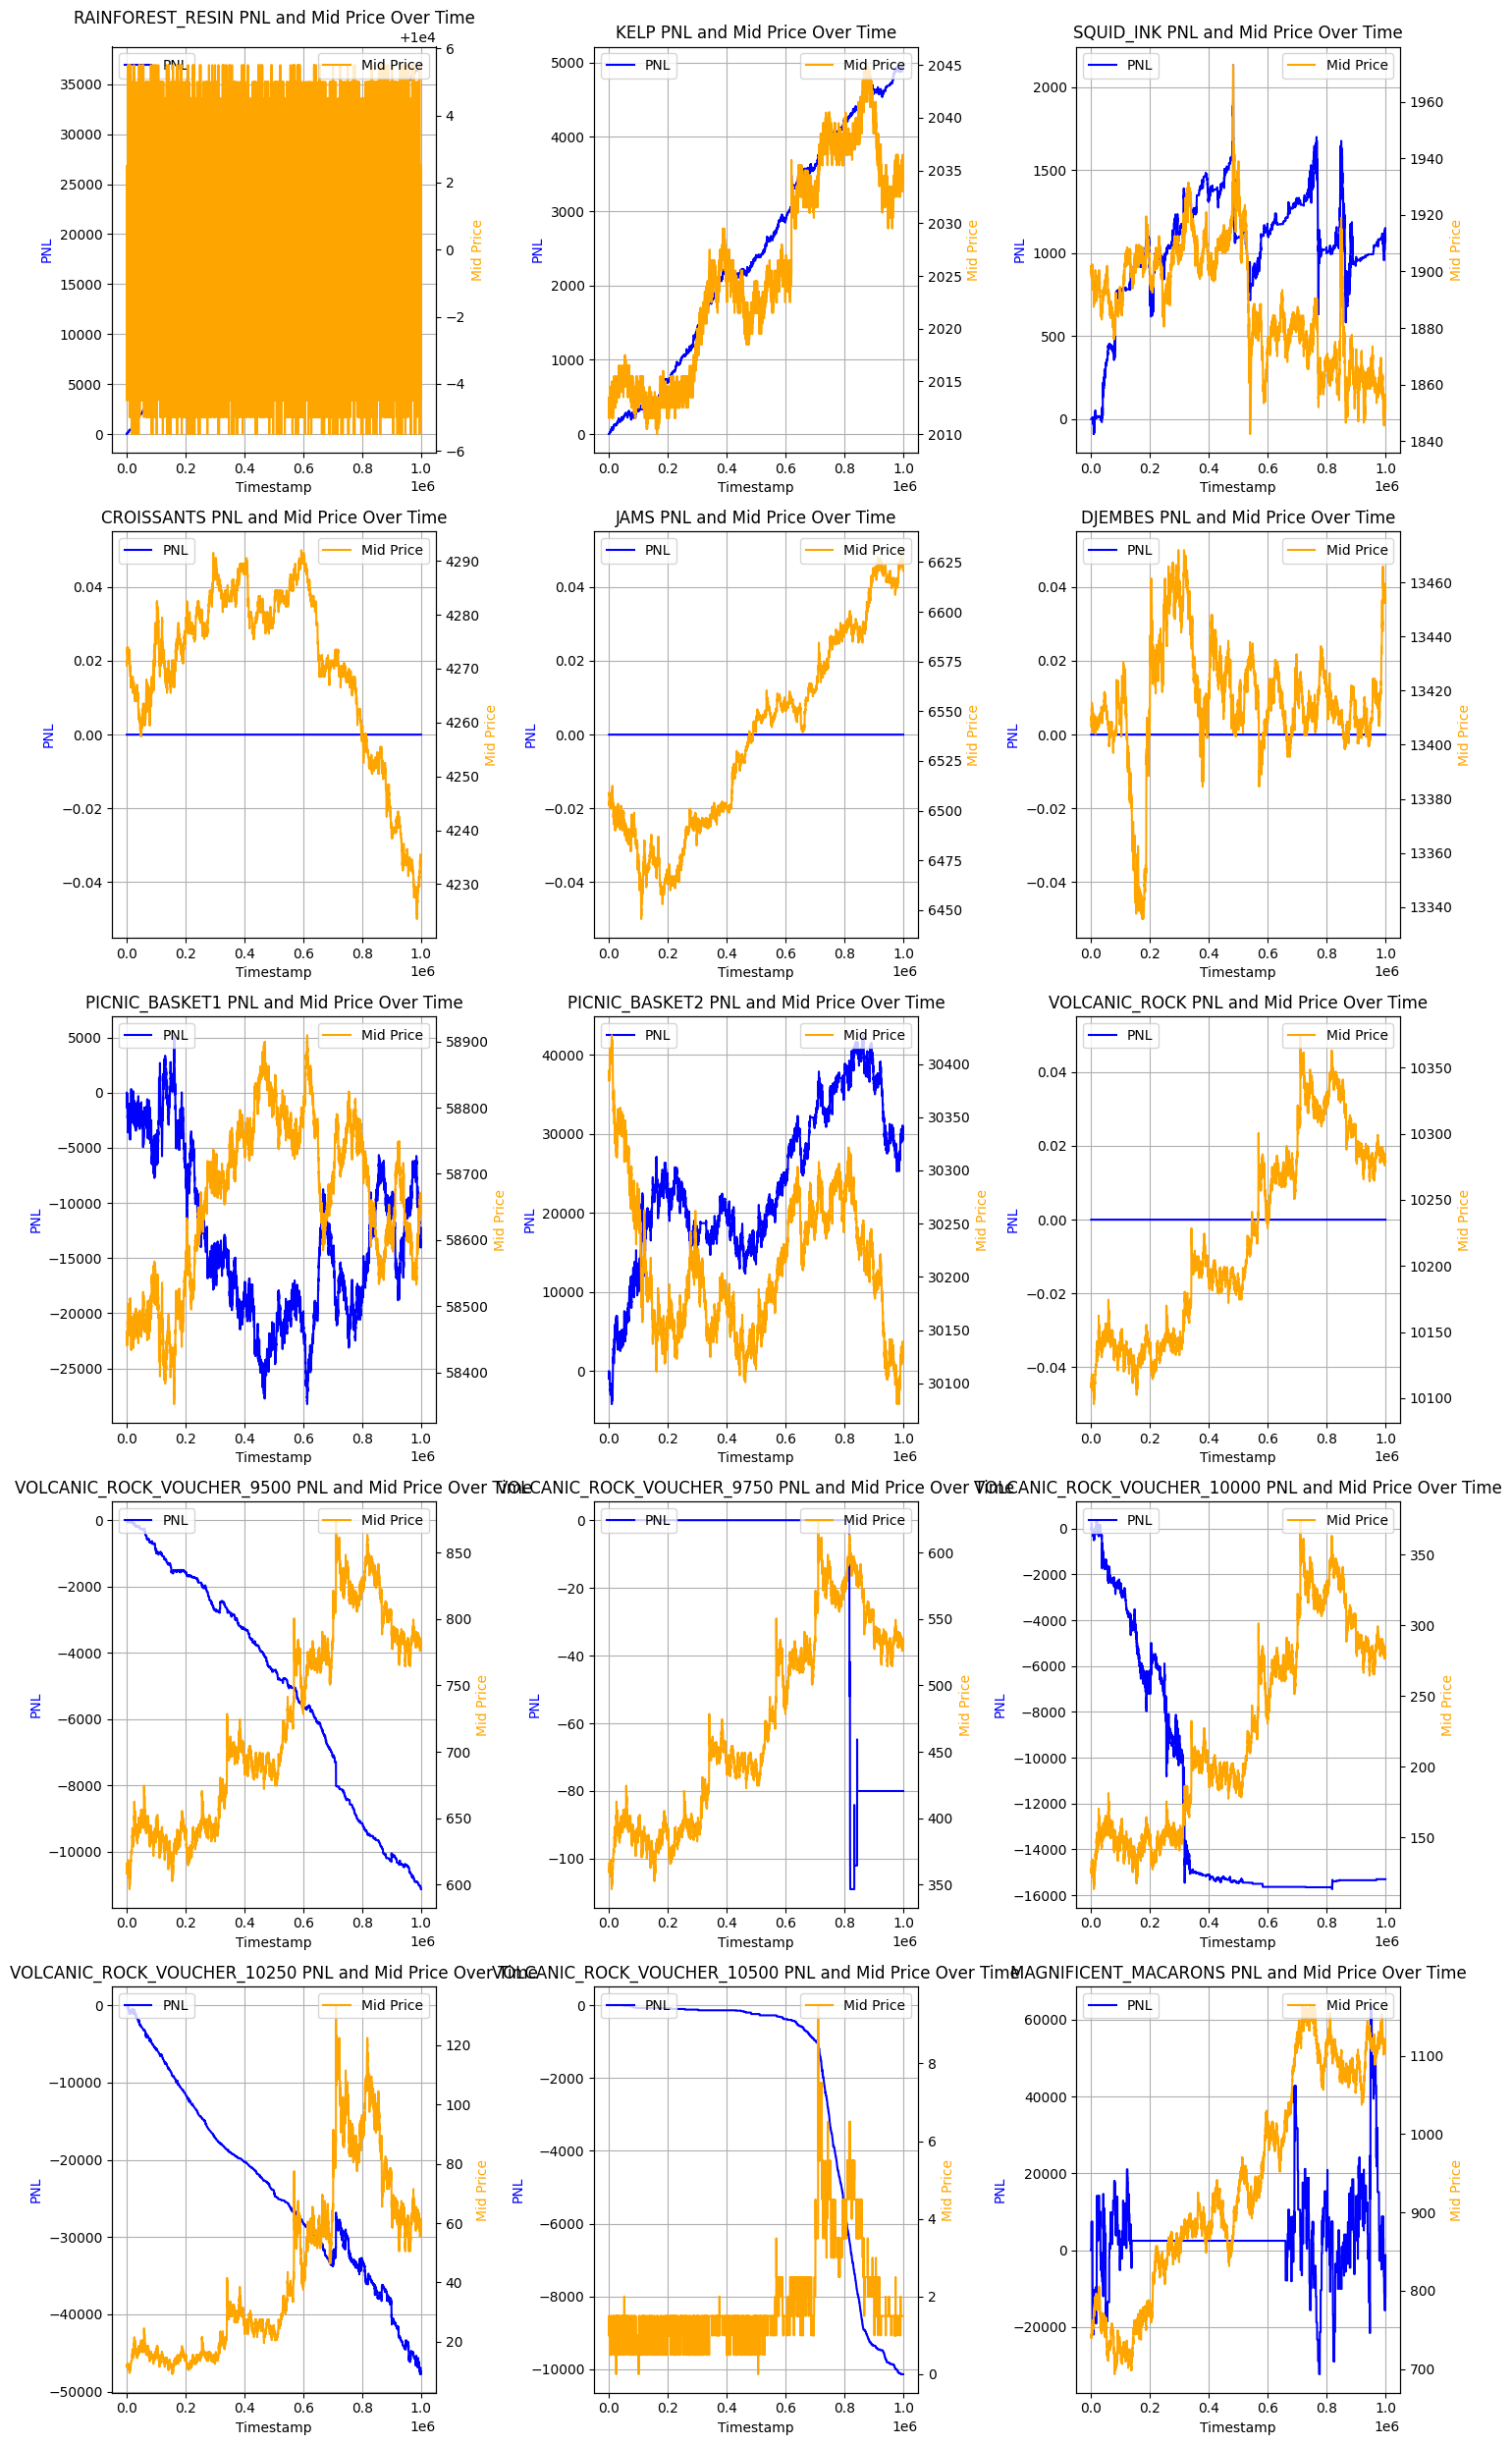

In [11]:
# Determine the number of products and grid size
num_products = len(product_dict)
cols = 3  # Number of columns in the grid
rows = (num_products + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each product's PnL and mid price in a subplot
for i, (product, data) in enumerate(product_dict.items()):
    ax = axes[i]
    if 'profit_and_loss' in data['order_book'].columns and 'mid_price' in data['order_book'].columns:
        ax.plot(data['order_book']['timestamp'], data['order_book']['profit_and_loss'], label='PNL', color='blue')
        ax.set_title(f'{product} PNL and Mid Price Over Time')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('PNL', color='blue')
        ax.grid()
        ax.legend(loc='upper left')

        # Create a secondary y-axis for mid price
        ax2 = ax.twinx()
        ax2.plot(data['order_book']['timestamp'], data['order_book']['mid_price'], label='Mid Price', color='orange')
        ax2.set_ylabel('Mid Price', color='orange')
        ax2.legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# VOLCANIC ROCK POSITIONS

In [12]:
def bisection_iv(
        S: float,
        V: float,
        K: int,
        TTT: float,
        low: float = 1e-4,
        high: float = 1.0,
        tol: float = 1e-4,
        max_iter: int = 10
) -> Tuple[float, float]:
    """
    Bisection method to find the implied volatility and delta.
    """
    N = NormalDist()
    for _ in range(max_iter):
        iv = (low + high) / 2
        d1 = (log(S / K) + (0.5 * high**2) * TTT) / (high * sqrt(TTT))
        d2 = d1 - high * sqrt(TTT)
        delta = N.cdf(d1)
        price = S * delta - K * N.cdf(d2)
        if abs(price - V) < tol:
            return iv, delta
        if price > V:
            high = iv
        else:
            low = iv
    return iv, delta

def newton_iv(
        S: float,
        V: float,
        K: int,
        TTE: float,
        iv: float = 0.2,
        tol: float = 1e-4,
        max_iter: int = 50
) -> Tuple[float, float]:
    """
    Newton's method to find the implied volatility and delta.
    """
    N = NormalDist()
    for _ in range(max_iter):
        d1 = (log(S / K) + (0.5 * iv**2) * TTE) / (iv * sqrt(TTE))
        d2 = d1 - iv * sqrt(TTE)
        delta = N.cdf(d1)
        price = S * delta - K * N.cdf(d2)
        vega = S * N.pdf(d1) * sqrt(TTE)
        if vega < 1e-5:
            return bisection_iv(S, V, K, TTE, low=1e-4, high=1.0, tol=tol)
        iv -= (price - V) / vega
        if abs(price - V) < tol:
            return iv, delta
    return iv, delta

def black_scholes_price(
        S: float,
        K: int,
        TTE: float,
        iv: float,
        r: float = 0.0
) -> float:
    """
    Calculate the Black-Scholes price.
    """
    N = NormalDist()
    d1 = (log(S / K) + (0.5 * iv**2) * TTE) / (iv * sqrt(TTE))
    d2 = d1 - iv * sqrt(TTE)
    call_price = S * N.cdf(d1) - K * exp(-r * TTE) * N.cdf(d2)
    return call_price

def add_volcanic_rock_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each row in df (with columns 'timestamp' and 'mid_price'), compute:
      - iv_{strike}, delta_{strike}
      - moneyness_{strike}
      - iv_fit_{strike}, misvol_{strike}, fair_{strike}
      - c (quadratic coefficient) and base_vol (constant term of the quadratic fit)
    for strikes = [9500, 9750, 10000, 10250, 10500], and append all as new cols.
    """
    strikes = [9500, 9750, 10000, 10250, 10500]
    
    def compute_row(row):
        S = row['mid_price']
        TTE = (3e6 - row['timestamp']) / (1e6 * 365)
        out = {}
        # 1) raw IV + delta + moneyness
        for K in strikes:
            # assume you've pre–merged in the voucher mid‐prices as e.g. mid_price_9500, etc.
            V = row[f'mid_price_{K}']
            iv, delta = newton_iv(S, V, K, TTE)
            m = np.log(K / S) / np.sqrt(TTE)
            out[f'iv_{K}'] = iv
            out[f'delta_{K}'] = delta
            out[f'moneyness_{K}'] = m
        
        # 2) fit a quadratic IV curve
        m_vals = [out[f'moneyness_{K}'] for K in strikes]
        iv_vals = [out[f'iv_{K}'] for K in strikes]
        a, b, c = np.polyfit(m_vals, iv_vals, 2)
        out['c'] = c  # quadratic coefficient
        out['base_vol'] = c  # constant term of the quadratic fit
        
        # 3) iv_fit, misvol, fair
        for K in strikes:
            m = out[f'moneyness_{K}']
            iv_fit = a*m*m + b*m + c
            fair = black_scholes_price(S, K, TTE, iv_fit)
            out[f'iv_fit_{K}']  = iv_fit
            out[f'misvol_{K}']  = out[f'iv_{K}'] - iv_fit
            out[f'fair_{K}']    = fair
        
        return pd.Series(out)
    
    # apply row‐wise and concat
    metrics = df.apply(compute_row, axis=1)
    return pd.concat([df, metrics], axis=1)


In [13]:
volcanic_rock_df = product_dict["VOLCANIC_ROCK"]["order_book"][["timestamp", "mid_price"]].copy()

strikes = [9500, 9750, 10000, 10250, 10500]
for K in strikes:
    voucher_df = (
        product_dict[f"VOLCANIC_ROCK_VOUCHER_{K}"]["order_book"]
        .loc[:, ["timestamp", "mid_price"]]
        .rename(columns={"mid_price": f"mid_price_{K}"})
    )
    volcanic_rock_df = volcanic_rock_df.merge(voucher_df, on="timestamp", how="left")

# now all mid_price_* columns are aligned by timestamp
volcanic_rock_df = add_volcanic_rock_metrics(volcanic_rock_df)

# inspect
for K in strikes:
    print(f"Strike {K}:")
    print(volcanic_rock_df[[f"mid_price_{K}", f"fair_{K}"]].describe())

print("c summary:", volcanic_rock_df["c"].describe())
print("base_vol summary:", volcanic_rock_df["base_vol"].describe())


Strike 9500:
       mid_price_9500     fair_9500
count    10000.000000  10000.000000
mean       720.983550    688.832812
std         73.650307    161.795561
min        596.500000   -101.122471
25%        645.500000    641.500239
50%        703.500000    697.500822
75%        784.500000    782.002860
max        874.500000    874.500000
Strike 9750:
       mid_price_9750     fair_9750
count    10000.000000  10000.000000
mean       471.093400    470.485873
std         73.489975     75.545294
min        346.500000   -320.411302
25%        395.500000    395.505303
50%        453.500000    453.059769
75%        534.500000    534.047688
max        624.500000    624.500001
Strike 10000:
       mid_price_10000    fair_10000
count     10000.000000  10000.000000
mean        225.561650    224.942945
std          69.513613     70.794941
min         113.500000   -359.728668
25%         154.500000    154.927721
50%         206.500000    205.987016
75%         284.500000    284.838921
max         374.

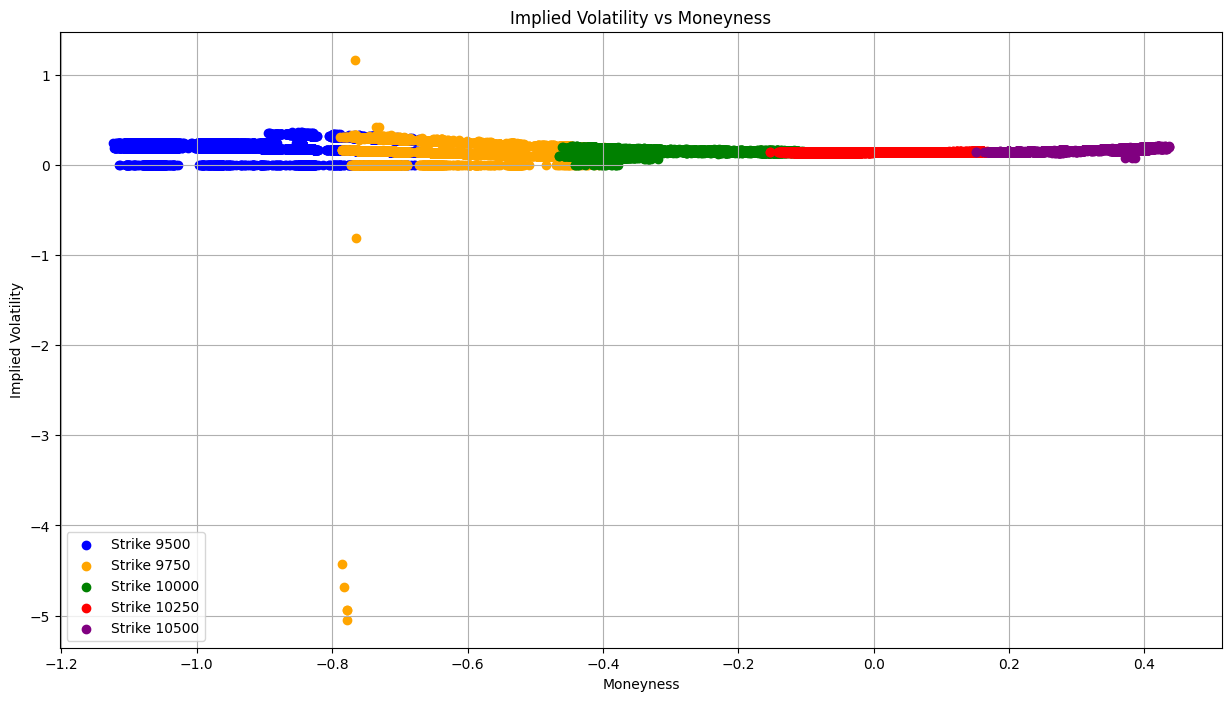

In [14]:
plt.figure(figsize=(15, 8))

strikes = [9500, 9750, 10000, 10250, 10500]
colors = ['blue', 'orange', 'green', 'red', 'purple']

for K, color in zip(strikes, colors):
    plt.scatter(volcanic_rock_df[f'moneyness_{K}'], volcanic_rock_df[f'iv_{K}'], label=f'Strike {K}', color=color)

plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Moneyness')
plt.legend()
plt.grid()
plt.show()

Strike 9500:
  Average difference: 32.1507382692251
  Standard deviation: 153.31961189952906
  5th percentile: -0.029624946741660094 (Adjusted: 32.12111332248344)
  95th percentile: 0.4999313651184821 (Adjusted: 32.650669634343586)
  Difference between average and 5th percentile: 32.180363215966764
  Difference between average and 95th percentile: 31.65080690410662


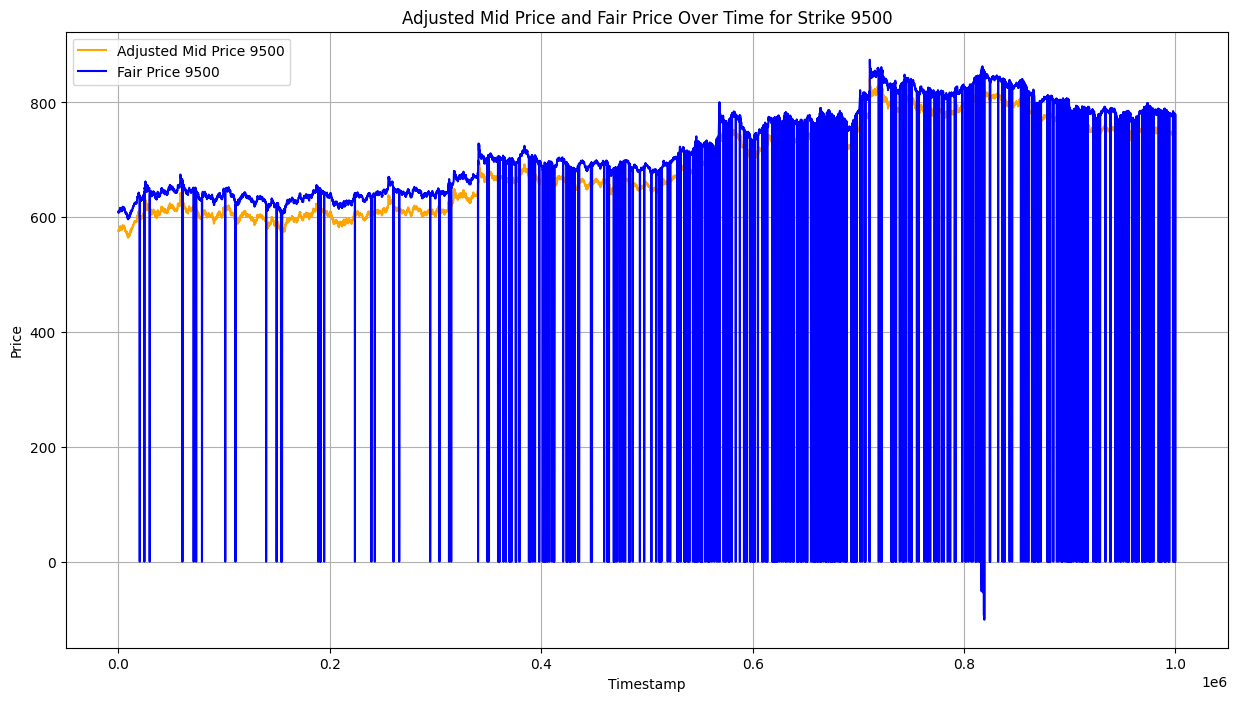

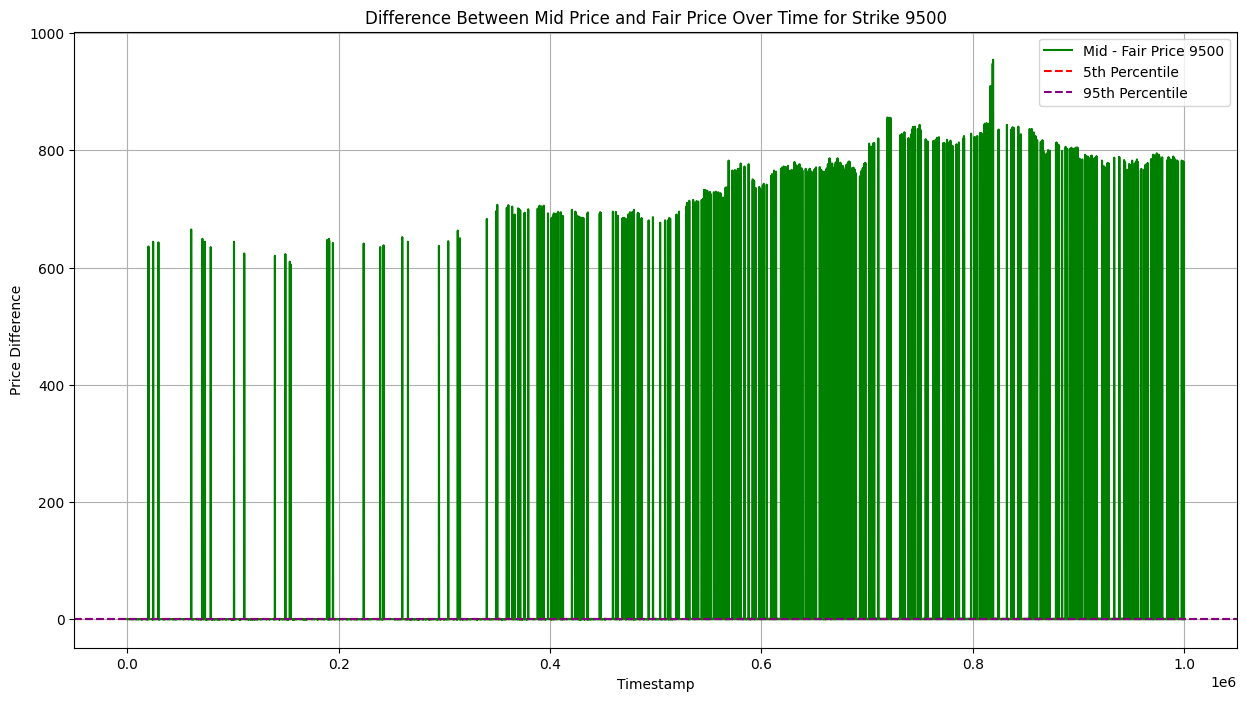

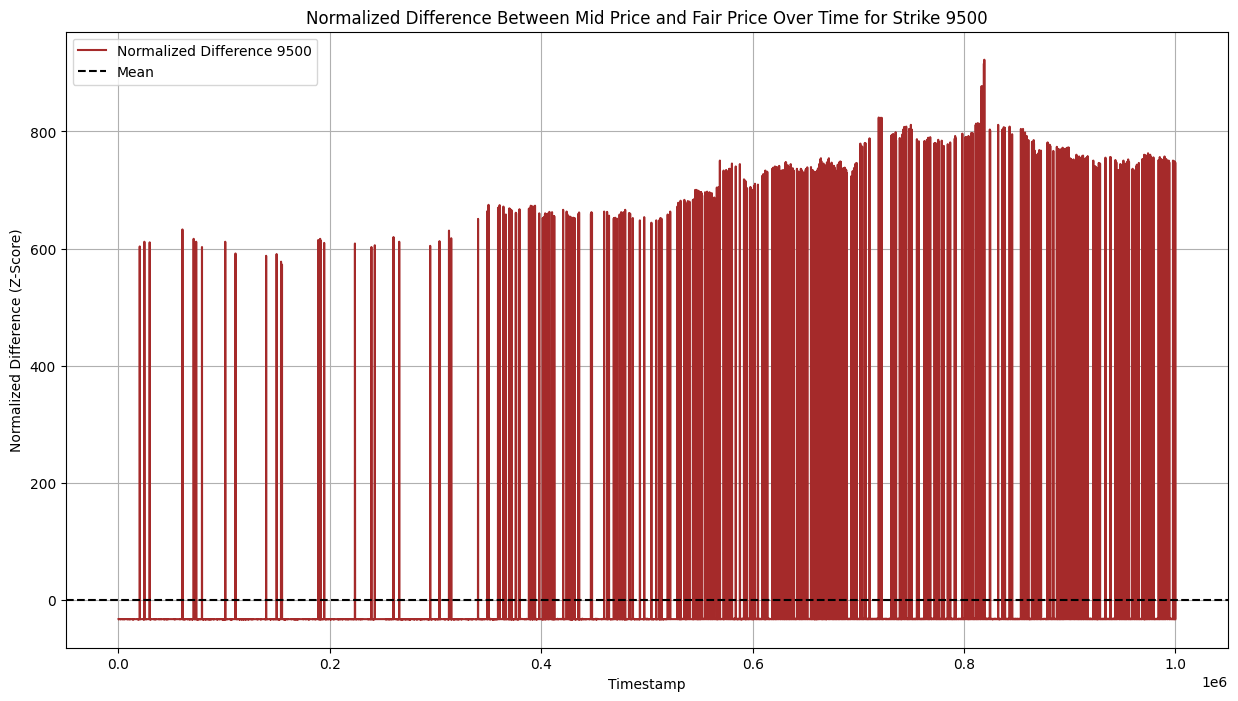

Strike 9750:
  Average difference: 0.6075267016623438
  Standard deviation: 20.839238117906508
  5th percentile: -0.5 (Adjusted: 0.1075267016623438)
  95th percentile: 0.7897333634441566 (Adjusted: 1.3972600651065004)
  Difference between average and 5th percentile: 1.1075267016623438
  Difference between average and 95th percentile: -0.18220666178181277


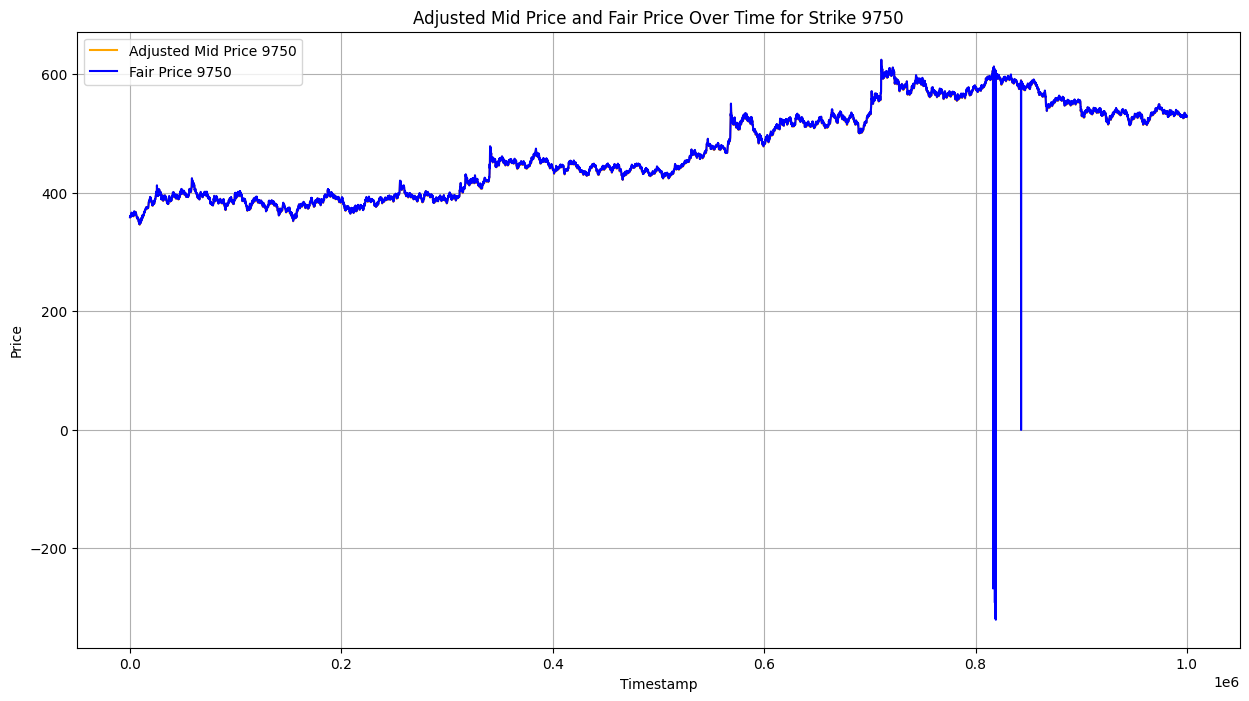

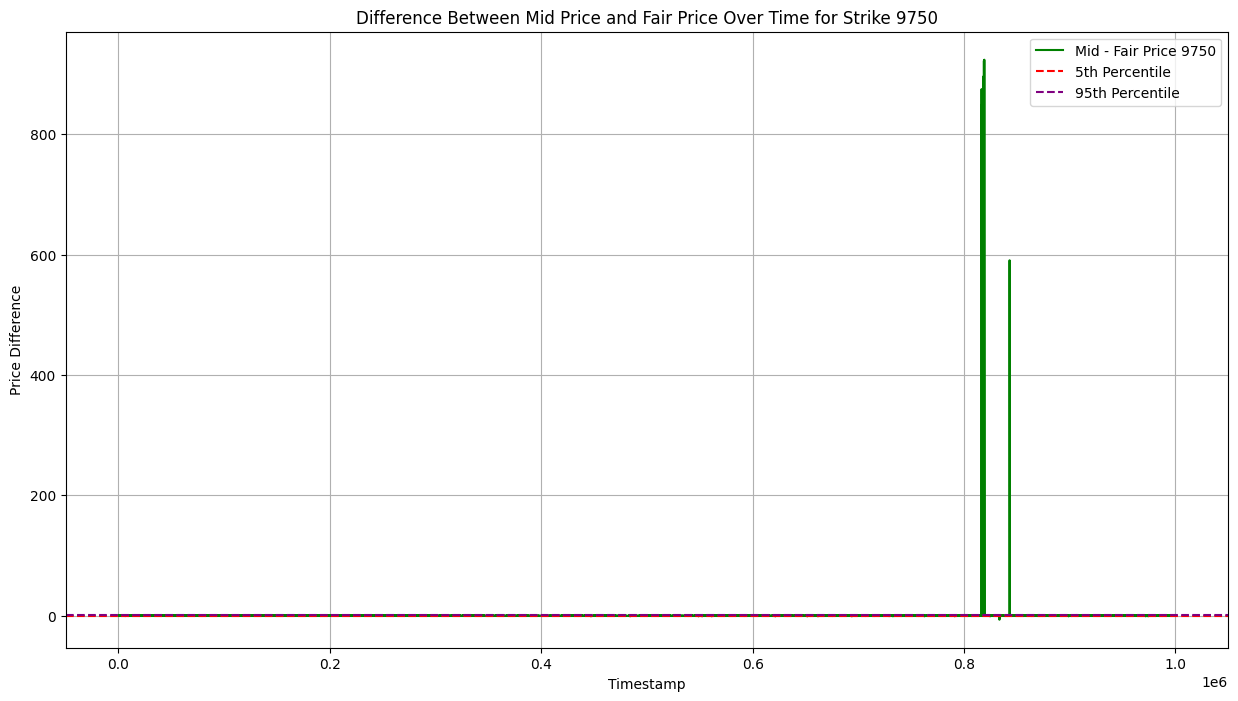

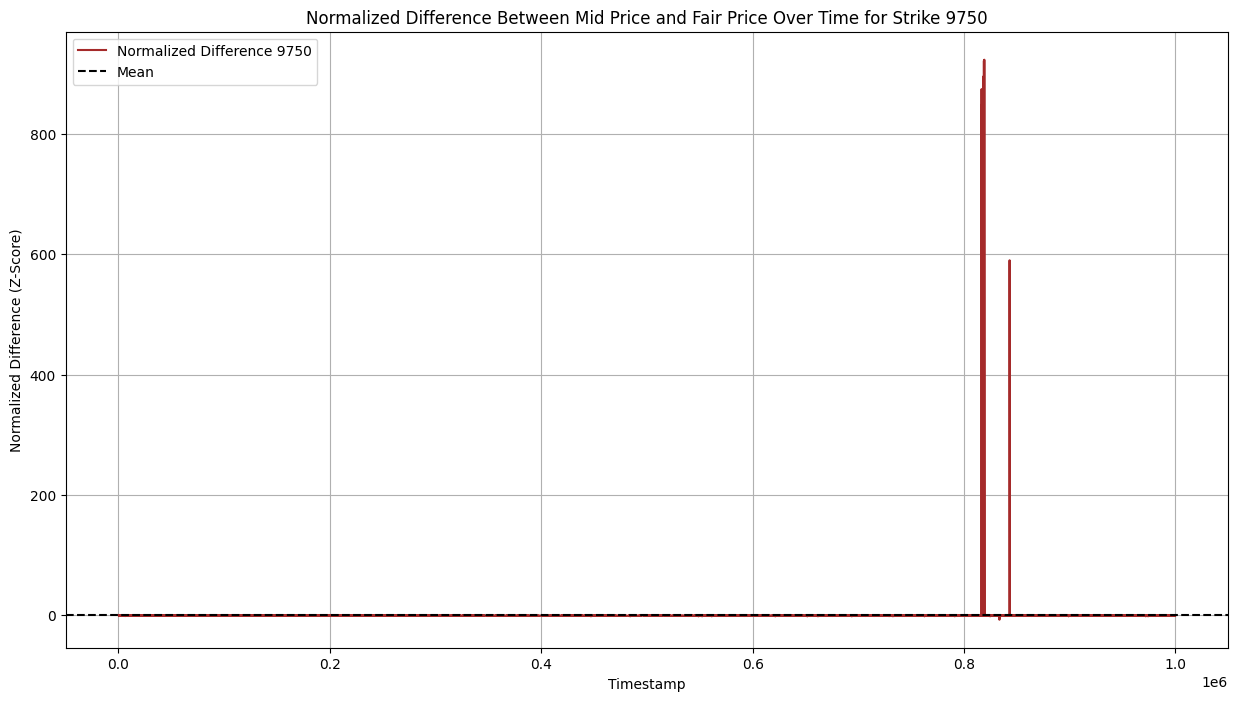

Strike 10000:
  Average difference: 0.6187049851079942
  Standard deviation: 16.05243185824901
  5th percentile: -3.551953010249963 (Adjusted: -2.9332480251419684)
  95th percentile: 4.286014524261099 (Adjusted: 4.904719509369094)
  Difference between average and 5th percentile: 4.170657995357957
  Difference between average and 95th percentile: -3.6673095391531048


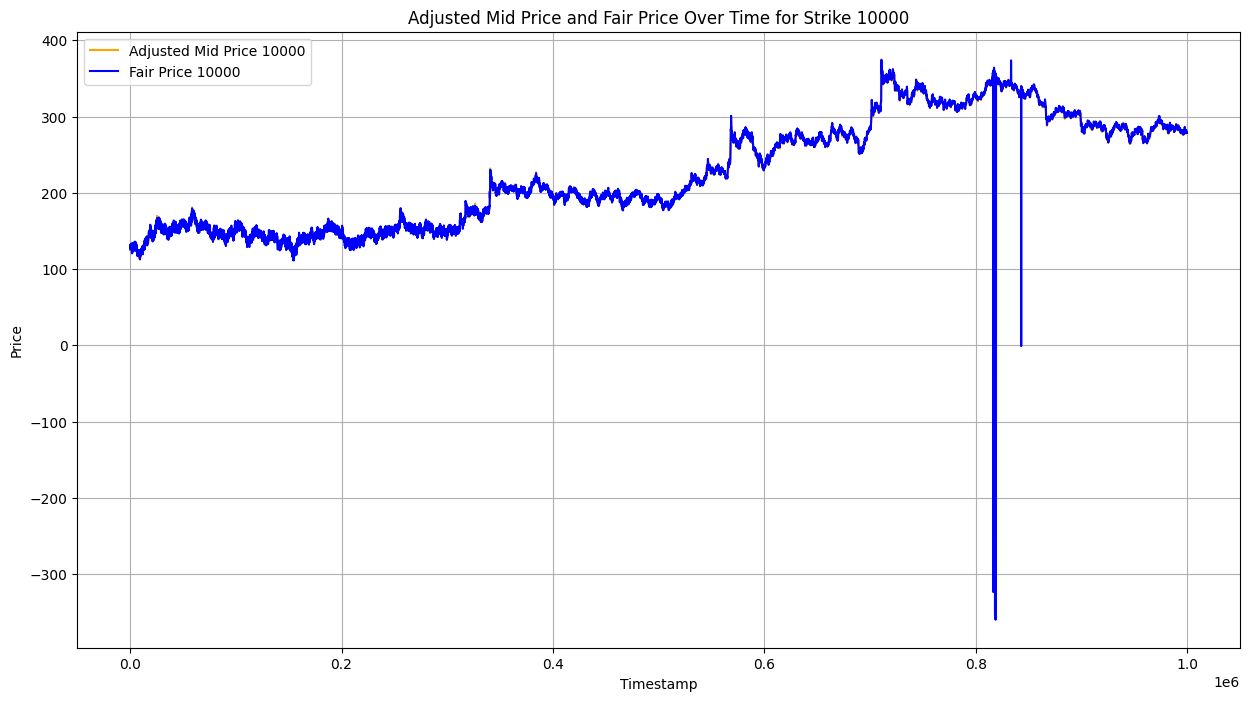

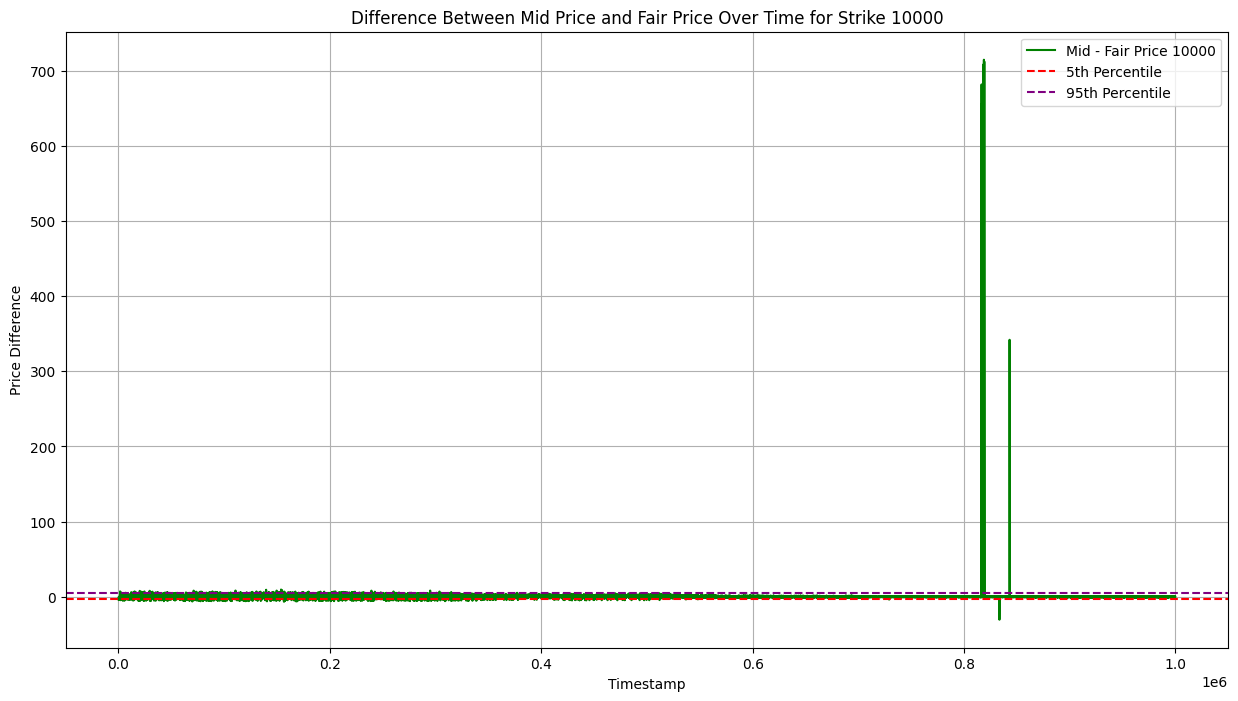

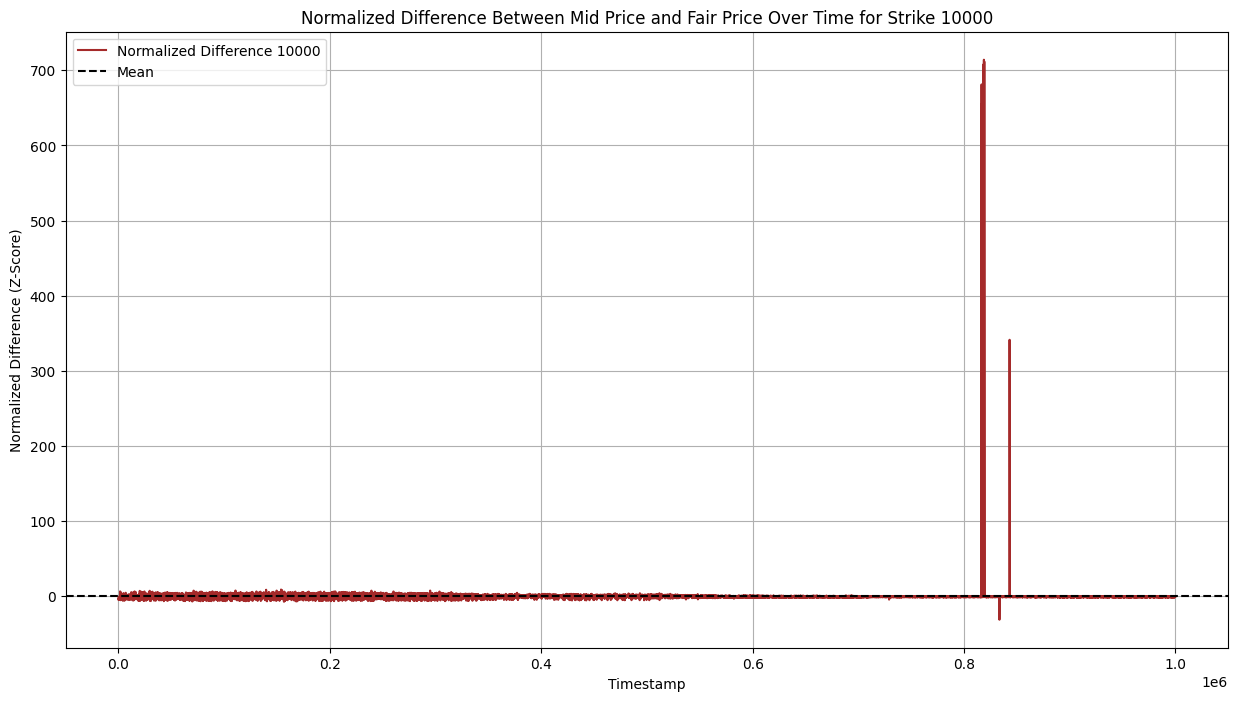

Strike 10250:
  Average difference: -1.5774339876729064
  Standard deviation: 7.676322999146211
  5th percentile: -7.685055701135821 (Adjusted: -9.262489688808728)
  95th percentile: 5.441992376240114 (Adjusted: 3.8645583885672075)
  Difference between average and 5th percentile: 6.1076217134629145
  Difference between average and 95th percentile: -7.01942636391302


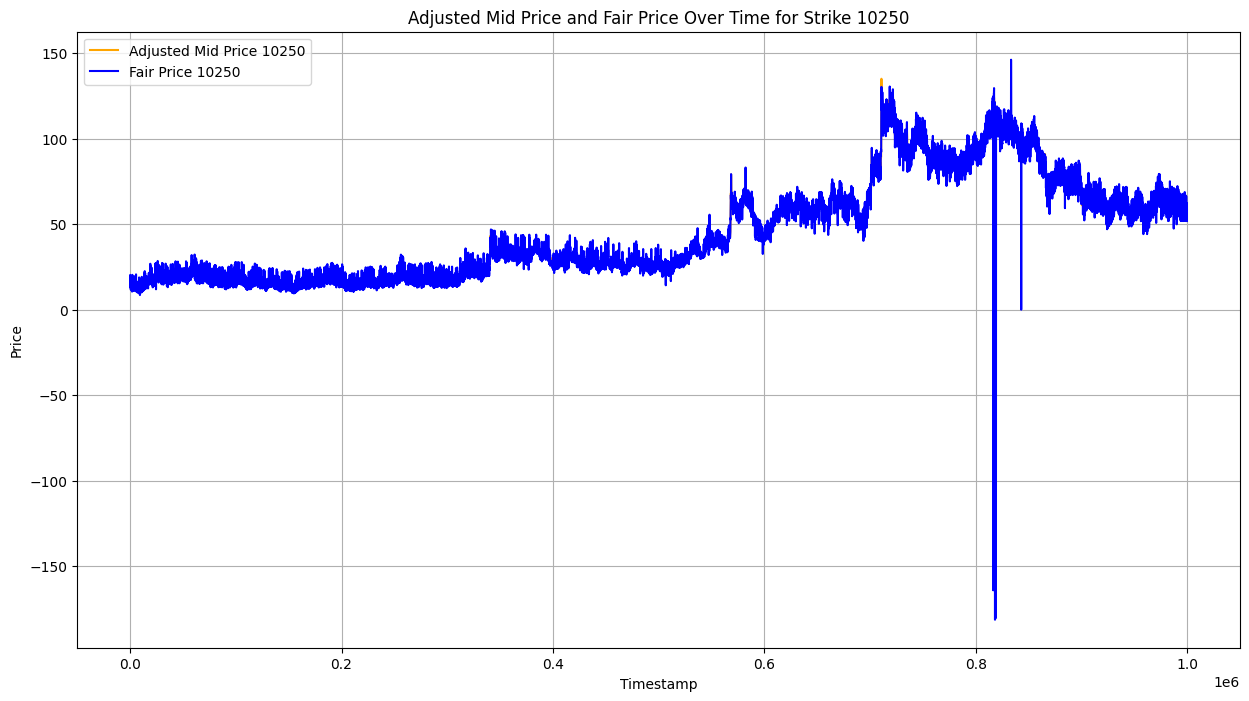

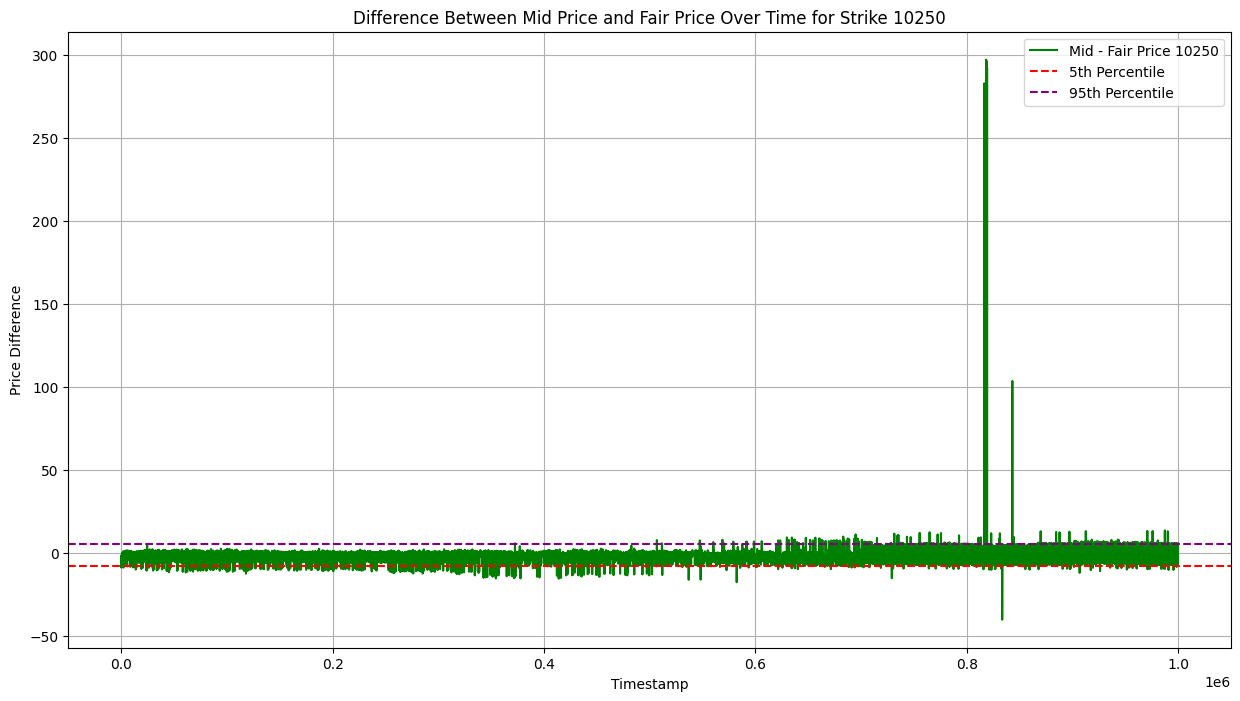

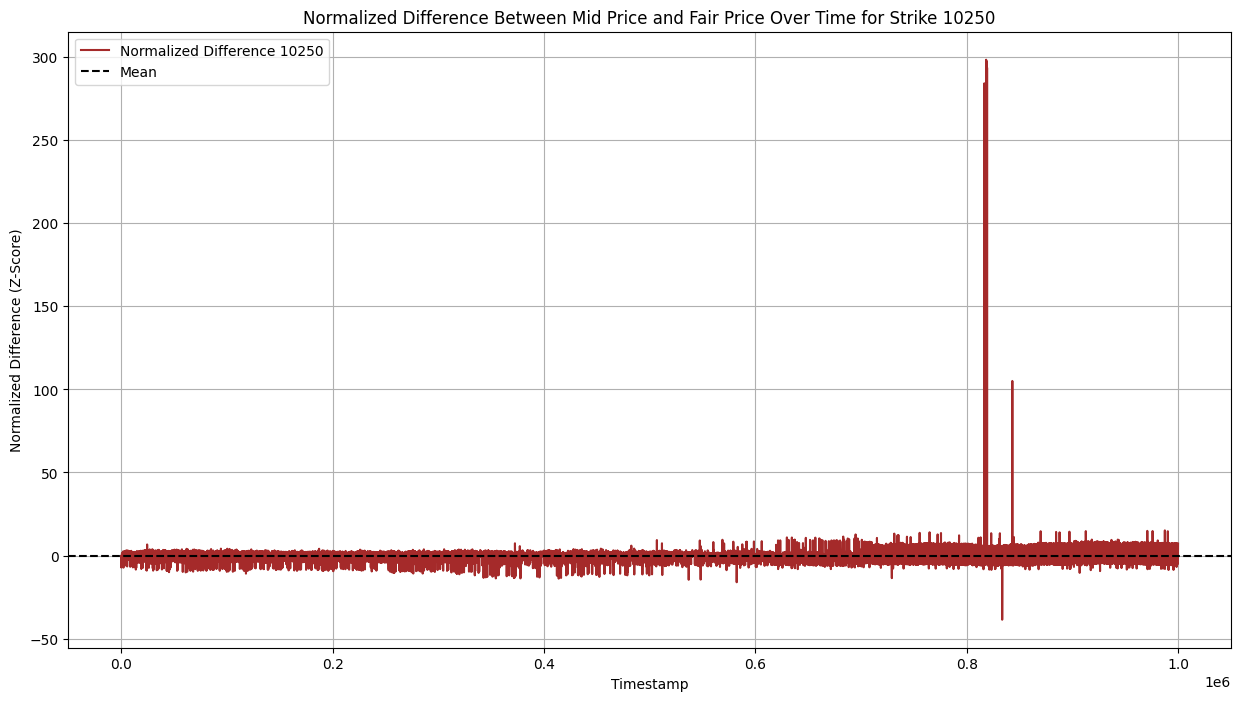

Strike 10500:
  Average difference: -0.025212229677604944
  Standard deviation: 5.042697557570337
  5th percentile: -0.7483804874932105 (Adjusted: -0.7735927171708155)
  95th percentile: 1.2246457015034082 (Adjusted: 1.1994334718258033)
  Difference between average and 5th percentile: 0.7231682578156056
  Difference between average and 95th percentile: -1.2498579311810132


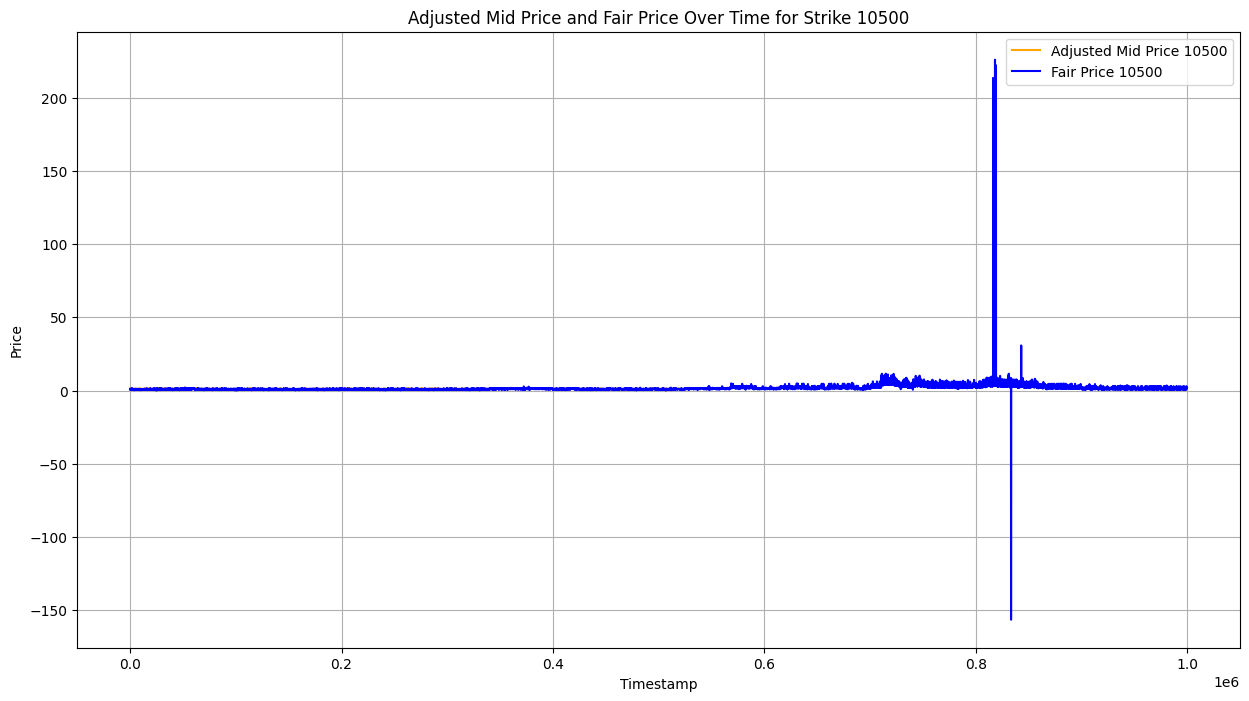

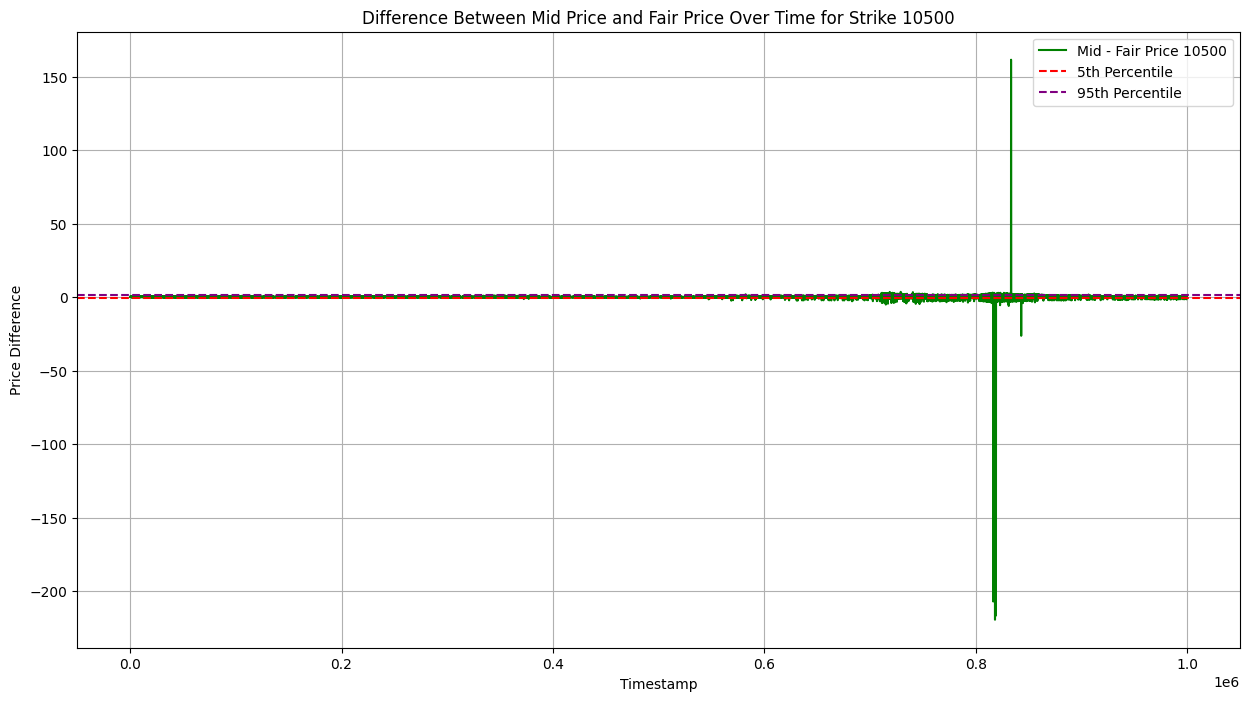

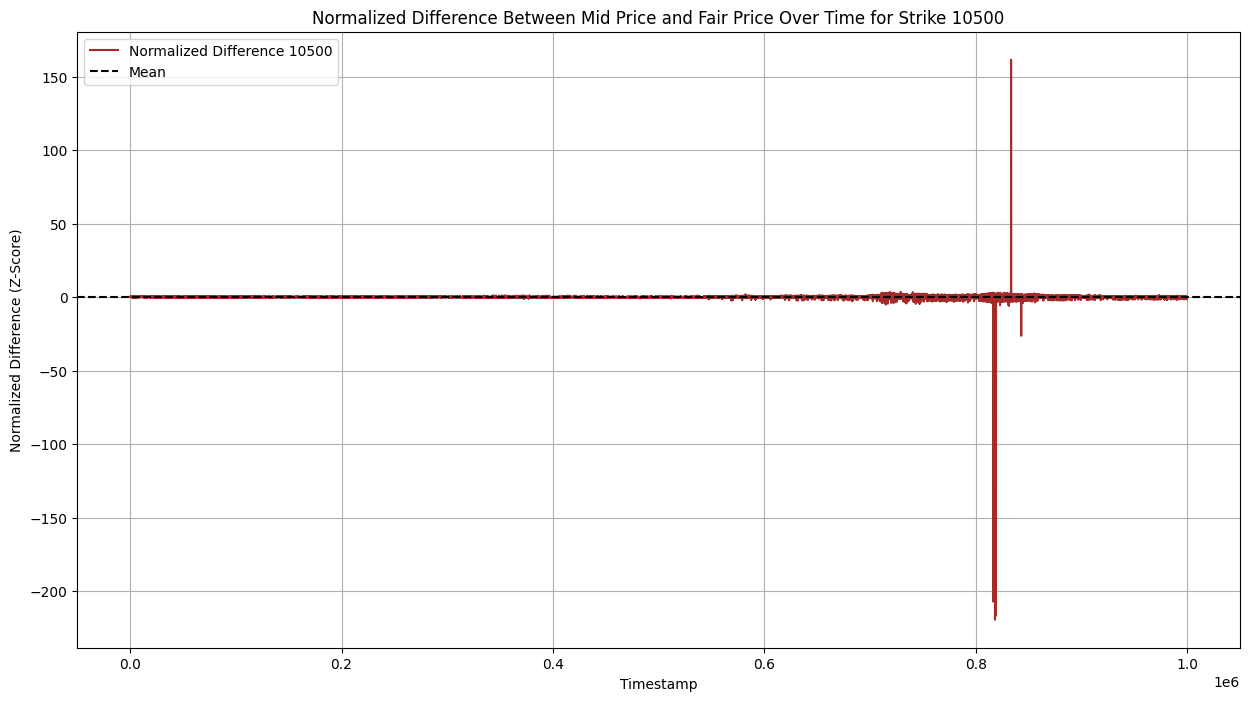

In [15]:
for K in [9500, 9750, 10000, 10250, 10500]:
    price_diff = volcanic_rock_df[f'mid_price_{K}'] - volcanic_rock_df[f'fair_{K}']
    avg_diff = price_diff.mean()
    std_diff = price_diff.std()
    percentile_5 = price_diff.quantile(0.05)
    percentile_95 = price_diff.quantile(0.95)
    
    # Normalize the difference (z-score)
    normalized_diff = (price_diff - avg_diff)
    
    print(f"Strike {K}:")
    print(f"  Average difference: {avg_diff}")
    print(f"  Standard deviation: {std_diff}")
    print(f"  5th percentile: {percentile_5} (Adjusted: {percentile_5 + avg_diff})")
    print(f"  95th percentile: {percentile_95} (Adjusted: {percentile_95 + avg_diff})")
    print(f"  Difference between average and 5th percentile: {avg_diff - percentile_5}")
    print(f"  Difference between average and 95th percentile: {avg_diff - percentile_95}")
    
    # Plot mid price (adjusted) and fair value
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], volcanic_rock_df[f'mid_price_{K}'] - avg_diff, label=f'Adjusted Mid Price {K}', color='orange')
    plt.plot(volcanic_rock_df['timestamp'], volcanic_rock_df[f'fair_{K}'], label=f'Fair Price {K}', color='blue')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title(f'Adjusted Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot the difference
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], price_diff, label=f'Mid - Fair Price {K}', color='green')
    plt.axhline(percentile_5, color='red', linestyle='--', label='5th Percentile')
    plt.axhline(percentile_95, color='purple', linestyle='--', label='95th Percentile')
    plt.xlabel('Timestamp')
    plt.ylabel('Price Difference')
    plt.title(f'Difference Between Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot the normalized difference
    plt.figure(figsize=(15, 8))
    plt.plot(volcanic_rock_df['timestamp'], normalized_diff, label=f'Normalized Difference {K}', color='brown')
    plt.axhline(0, color='black', linestyle='--', label='Mean')
    plt.xlabel('Timestamp')
    plt.ylabel('Normalized Difference (Z-Score)')
    plt.title(f'Normalized Difference Between Mid Price and Fair Price Over Time for Strike {K}')
    plt.legend()
    plt.grid()
    plt.show()

# BASKET

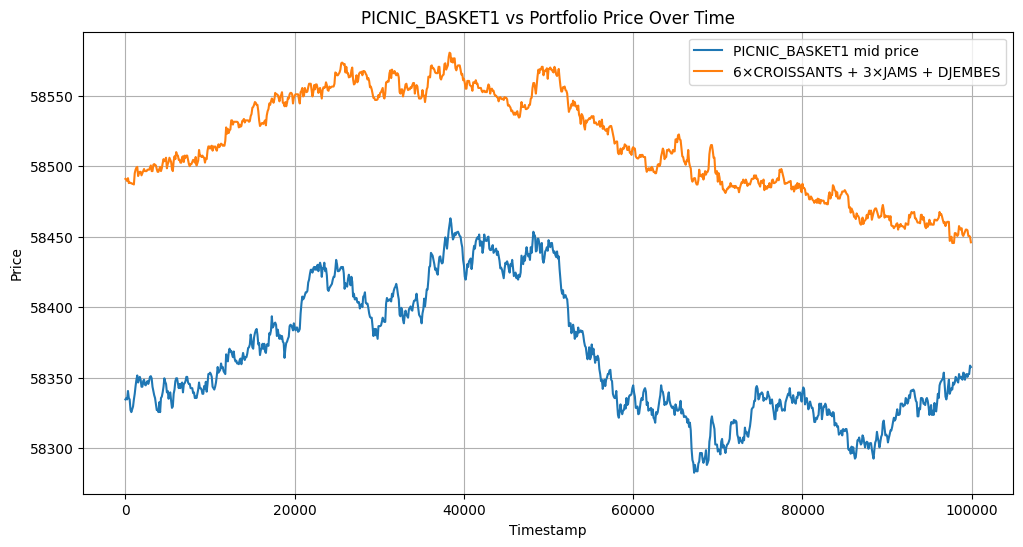

In [25]:
# Extract mid‐price series
picnic = product_dict["PICNIC_BASKET1"]["order_book"][["timestamp", "mid_price"]]
croissants = product_dict["CROISSANTS"]["order_book"][["timestamp", "mid_price"]].rename(columns={"mid_price": "mid_price_croissants"})
jams = product_dict["JAMS"]["order_book"][["timestamp", "mid_price"]].rename(columns={"mid_price": "mid_price_jams"})
djembes = product_dict["DJEMBES"]["order_book"][["timestamp", "mid_price"]].rename(columns={"mid_price": "mid_price_djembes"})

# Align on timestamp
combo = (picnic
         .merge(croissants, on="timestamp")
         .merge(jams, on="timestamp")
         .merge(djembes, on="timestamp"))

# Compute weighted portfolio price
combo["portfolio_price"] = (
    6 * combo["mid_price_croissants"]
  + 3 * combo["mid_price_jams"]
  + 1 * combo["mid_price_djembes"]
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(picnic["timestamp"], picnic["mid_price"], label="PICNIC_BASKET1 mid price", color="tab:blue")
plt.plot(combo["timestamp"], combo["portfolio_price"],
         label="6×CROISSANTS + 3×JAMS + DJEMBES", color="tab:orange")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("PICNIC_BASKET1 vs Portfolio Price Over Time")
plt.legend()
plt.grid()
plt.show()